## Домашнее задание №10 по курсу «Машинное обучение»: k-NN
#### 1. реализуйте k-NN алгоритм для задачи классификации. Для датасета Ирисы Фишера найдите оптимальное значение k с помощью кросс-валидации.


In [3]:
import pandas as pd
import io
import requests
import numpy as np
from collections import Counter
from scipy.spatial.distance import euclidean
import matplotlib.pyplot as plt
%matplotlib inline

# Load data from url in list
def load_data():
    url="http://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data"
    s=requests.get(url).content
    data=pd.read_csv(io.StringIO(s.decode('utf-8')),index_col=False,header=None)
    dict  = {4:{'Iris-setosa':0,'Iris-versicolor':1,'Iris-virginica':2}}
    data.replace(to_replace=dict,inplace=True)
    return  data.values.tolist()

In [21]:
def load_data():
    url="http://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data"
    s=requests.get(url).content
    data=pd.read_csv(io.StringIO(s.decode('utf-8')),index_col=False,header=None)
    dict  = {4:{'Iris-setosa':0,'Iris-versicolor':1,'Iris-virginica':2}}
    data.replace(to_replace=dict,inplace=True)
    return  data.values.tolist()


def split_train_test(dataset, train_ratio,test_ratio):
    train_size = int( train_ratio * len(dataset) / ( train_ratio + test_ratio)) 
    np.random.shuffle(dataset)
    train, test = dataset[:train_size], dataset[train_size:]   
    return train, test
       

# Split a dataset into k folds
def cross_validation_split(dataset, n_folds):
    fold_size = int(len(dataset) / n_folds)
    np.random.shuffle(dataset)
    splits = []
    for i in xrange(n_folds):
        part_before = dataset[:fold_size*i]
        part_after = dataset[fold_size*(i + 1):]
        validation_part = dataset[fold_size*i : fold_size*(i + 1)]
        training_part = part_before + part_after
        splits.append((training_part, validation_part))
    return splits


def get_risk(predictions, true_labels):
    predictions=np.array(predictions)
    true_labels=np.array(true_labels)
    wrong = np.sum(predictions != true_labels)
    return float(wrong) / len(true_labels)

In [22]:
def knn_predict_class(k, X_to_classify, X_train, y_train):
    distances = [(euclidean(X_to_classify,X),y) for X, y in zip(X_train,y_train)]
    sotred_distances =  sorted(distances, key=lambda v: v[0])
    nearest_k_y = [item[1] for item in sotred_distances][:k]
    label = Counter(nearest_k_y).most_common(1)[0][0]
    return label

# K-Fold Cross Validation

In [46]:
dataset = load_data()
train, test = split_train_test(dataset, 8, 2)

K = range(1, 100)
cv = 5

def param_tunning(K):
    
    risks = [0 for i in xrange(len(K))]
    splits = cross_validation_split(train, cv)
    
    for  split in splits:
        train_split, validation_split = split
        
        split_X_train = [sublist[:4] for sublist in train_split]
        split_y_train = [sublist[-1] for sublist in train_split]
        split_X_validation = [sublist[:4] for sublist in validation_split]
        split_y_validation = [sublist[-1] for sublist in validation_split]

        for i, k  in enumerate(K):
            predicted = [knn_predict_class(k, x, split_X_train, split_y_train) for x in split_X_validation]
            risks[i] += get_risk(predicted, split_y_validation)
   
    risks = [ r/len(splits) for r in risks]
    return risks

risks = param_tunning(K)

In [69]:
min_risk = min(risks)
best_k_idxs = [i for i, risk in enumerate(risks) if risk == min_risk]
best_ks = [K[i] for i in best_k_idxs]
best_ks

[6, 8]

In [71]:
best_k_idx = best_k_idxs[0]
best_k = best_ks[0]
print("При k = %d ошибка на кросс-валидации минимальна и равна %f." % (best_k,min_risk))

При k = 6 ошибка на кросс-валидации минимальна и равна 0.000000.


# K-nn for test set

In [77]:

X_train = [sublist[:4] for sublist in train]
y_train = [sublist[-1] for sublist in train]
X_test = [sublist[:4] for sublist in test]
y_test = [sublist[-1] for sublist in test]

test_risks = [0 for i in xrange(len(K))]
for i, k  in enumerate(K):
    predicted = [knn_predict_class(k, x, X_train, y_train) for x in X_test]
    test_risks[i] = get_risk(predicted, y_test)


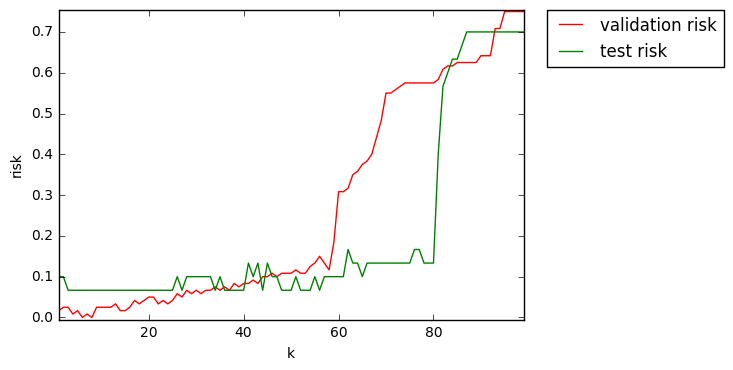

In [81]:
def plot(K, risks, test_risks):
    plt.xlabel("k")
    plt.ylabel("risk")
    plt.plot(K,risks,'r', label="validation risk")
    plt.plot(K,test_risks,'g' , label = "test risk")
    plt.axis([min(K),max(K),min(risks + test_risks) - 0.005,max(risks + test_risks) + 0.005])
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    return plt

plot(K, risks, test_risks).show()

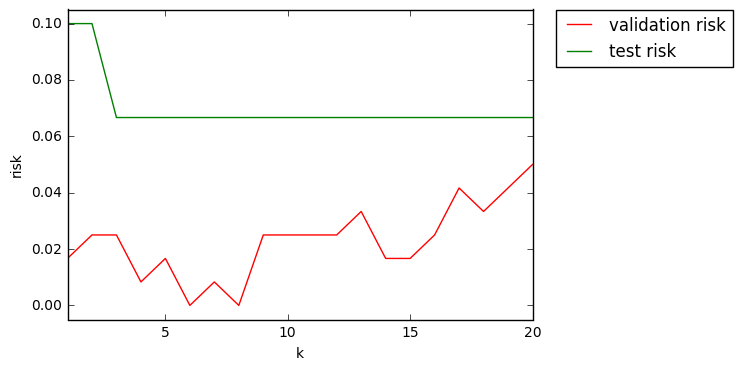

In [82]:
plot(K[:20], risks[:20], test_risks[:20]).show()

In [84]:
print("При k = %d ошибка на тестовой выборке минимальна и равна %f." % (best_k,test_risks[best_k_idxs[0]])) 

При k = 6 ошибка на тестовой выборке минимальна и равна 0.066667.


#### 2. как вы понимаете выражение «проклятие размерности»? Какие есть способы бороться с этим явлением в машинном обучении?

Если рассматривать объект как точку в пространсве признаков, то чем больше признаков, тем больше размерность пространства.
Проклятие размерности заключается в экспненциальном росте размера выборки от размерности пространства для достижения заданной точности. 
Это легко себе представить просто оценив соотношение объема гиперсферы с объемом гиперкуба, в который она вписана. Гиперсфера - область в которой объекты считаются похожими, а гиперкуб - пространство признаков. При увеличении количества признаков, для того чтобы охватить требуемое количество объектов, нужно по экспоненте увеличивать расстояние  поиска. А это, в свою очередь, приведет к тому, что в охват попадут далекие друг от друга объекты - совсем не "соседи". То есть получается, что для больших n близость объектов в терминах метрического расстояния все меньше соответствует схожести объектов в реальном мире.  

Увеличение размерности пространства вызывает проблемы -  трудоемкость вычислений, рост требуемых размеров выборки, памяти и т.д.

Борятся с проклятием размерности с помощью азмерности.   
Это можно сделать отбором признаков или проецированием(преобразование) признаков в пространство меньшей размерности или отбором признаков.  

Отбор признаков можно осуществлять экспертно, случайно, на основе каких-то оценок важности признаков (например, оценки можно получить из весов, полученных на градиентном бустинге)  

Преобразование признаков можно осуществить методом главных компонент, каким-либо агрегированием признаков (например, для изображений можем сделать банальное понижение разрешения).  
